# 0. Import bibliotek

In [1]:
import os
import numpy as np
import pandas as pd

# Wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns
sns.set(style="darkgrid", palette="muted", color_codes=True)

## Preprocesing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

import itertools

from scipy.ndimage import gaussian_filter1d

#### Modele 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from optuna.integration import TFKerasPruningCallback
import optuna


# 1. Analiza danych

In [2]:
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
train['date'] = pd.to_datetime(train['date']).dt.to_period('D')
#train = train.set_index('date') 

In [3]:
train.head(10)

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype    
---  ------    --------------   -----    
 0   id        136950 non-null  int64    
 1   date      136950 non-null  period[D]
 2   country   136950 non-null  object   
 3   store     136950 non-null  object   
 4   product   136950 non-null  object   
 5   num_sold  136950 non-null  int64    
dtypes: int64(2), object(3), period[D](1)
memory usage: 6.3+ MB


In [5]:
multi_index = pd.MultiIndex.from_frame(train[['date' , 'id']], names =  ['date' , 'id'])
train.set_index(multi_index, inplace=True)
train = train.drop(columns=['id', 'date'])

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 136950 entries, (Period('2017-01-01', 'D'), 0) to (Period('2021-12-31', 'D'), 136949)
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   country   136950 non-null  object
 1   store     136950 non-null  object
 2   product   136950 non-null  object
 3   num_sold  136950 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 10.1+ MB


In [7]:
enc = OrdinalEncoder()
Enc_col = ['country', 'store', 'product' ]

# Fit the encoder and create the mapping for each column separately
categories = {}
for col in Enc_col:
    for df in [train, test]:
        df[col + '_Enc'] = enc.fit_transform(df[col].values.reshape(-1, 1))
    categories[col] = enc.categories_[0]  # Store categories for the current column

# Print the mapping
for col in Enc_col:
    print(f"Kolumna: {col}")
    for i, category in enumerate(categories[col]):
        print(f"  Wartość zakodowana: {i} -> Wartość początkowa: {category}")

Kolumna: country
  Wartość zakodowana: 0 -> Wartość początkowa: Argentina
  Wartość zakodowana: 1 -> Wartość początkowa: Canada
  Wartość zakodowana: 2 -> Wartość początkowa: Estonia
  Wartość zakodowana: 3 -> Wartość początkowa: Japan
  Wartość zakodowana: 4 -> Wartość początkowa: Spain
Kolumna: store
  Wartość zakodowana: 0 -> Wartość początkowa: Kagglazon
  Wartość zakodowana: 1 -> Wartość początkowa: Kaggle Learn
  Wartość zakodowana: 2 -> Wartość początkowa: Kaggle Store
Kolumna: product
  Wartość zakodowana: 0 -> Wartość początkowa: Using LLMs to Improve Your Coding
  Wartość zakodowana: 1 -> Wartość początkowa: Using LLMs to Train More LLMs
  Wartość zakodowana: 2 -> Wartość początkowa: Using LLMs to Win Friends and Influence People
  Wartość zakodowana: 3 -> Wartość początkowa: Using LLMs to Win More Kaggle Competitions
  Wartość zakodowana: 4 -> Wartość początkowa: Using LLMs to Write Better


In [8]:
train = train.drop(columns=['country', 'store', 'product'])
Argentina  = train[train['country_Enc'] == 0]
Canada     = train[train['country_Enc'] == 1]
Estonia    = train[train['country_Enc'] == 2]
Japan      = train[train['country_Enc'] == 3]
Japan      = train[train['country_Enc'] == 4]

Argentina  = Argentina.drop(columns= 'country_Enc')
Canada     = Canada.drop(columns= 'country_Enc')

In [9]:
Argentina.head()

num_sold  store_Enc  product_Enc
date       id                                  
2017-01-01 0         63        1.0          0.0
           1         66        1.0          1.0
           2          9        1.0          2.0
           3         59        1.0          3.0
           4         49        1.0          4.0

In [10]:
import itertools

store_codes = Argentina['store_Enc'].unique()
product_codes = Argentina['product_Enc'].unique()

# Filter valid combinations based on existing data
valid_combos = [(s, p) for s in store_codes for p in product_codes]
# Create new column names from the valid combinations
new_column_names = [f'store_{s}_product_{p}' for s, p in valid_combos]
combo_df = pd.DataFrame(columns=new_column_names)

def fill_values(argentina_df, combine_df, target_cols=None):
  num_sold_values = argentina_df['num_sold'].values

  # Calculate the required number of rows
  num_rows = len(num_sold_values) // len(combine_df.columns)
  if len(num_sold_values) % len(combine_df.columns) != 0:
    raise ValueError("Number of 'num_sold' values not evenly divisible by number of columns in combo_df")

  # Create a new DataFrame with the required shape
  filled_df = pd.DataFrame(index=range(num_rows), columns=combine_df.columns)

  # Fill the values
  for row_num in range(num_rows):
    start_idx = row_num * len(combine_df.columns)
    end_idx = start_idx + len(combine_df.columns)
    if target_cols is None:
      filled_df.iloc[row_num, :] = num_sold_values[start_idx:end_idx]
    else:
      for col in target_cols:
        if col in combine_df.columns:
          filled_df.loc[row_num, col] = num_sold_values[start_idx:end_idx]
        else:
          print(f"Column '{col}' not found in combo_df")

  return filled_df

# Call the function and assign the result to 'df'
df = fill_values(Argentina, combo_df)


df.index = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
df = df.apply(pd.to_numeric, errors='coerce')
df = df.select_dtypes(include=['number']).astype('int32')

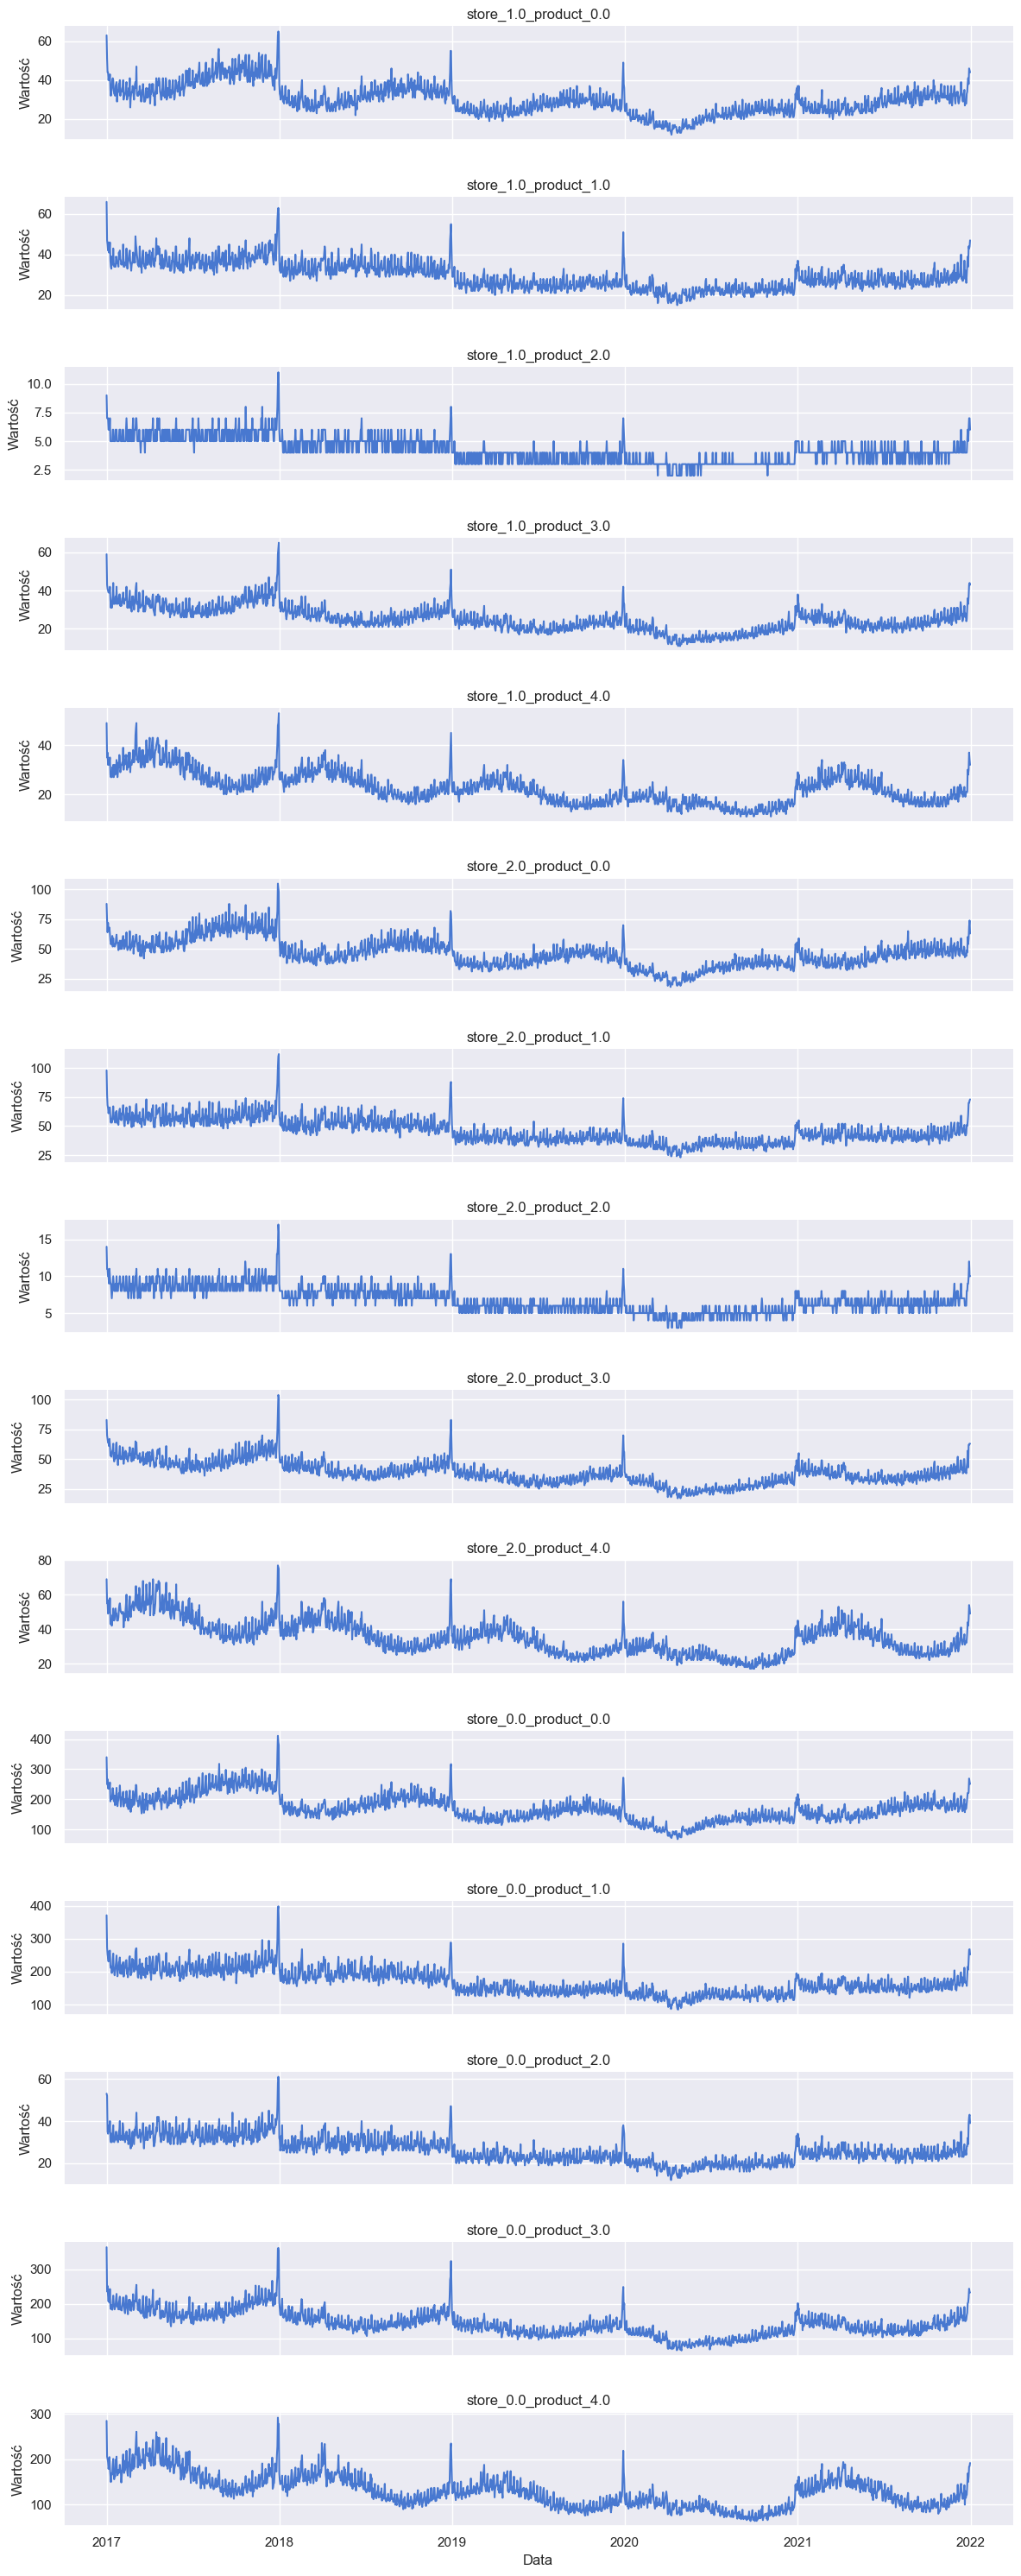

In [11]:
# Reshape the DataFrame to long format for FacetGrid
df_melted = df.melt(ignore_index=False).reset_index()

# Create a FacetGrid with a row for each column
g = sns.FacetGrid(df_melted, row="variable", sharey=False, aspect=6, height=2)

# Map line plots to each facet (subplot)
g.map(sns.lineplot, "index", "value")

# Adjust layout and display the figure
g.set_axis_labels("Data", "Wartość")  
g.set_titles(row_template="{row_name}")
plt.subplots_adjust(hspace=0.5)  # Zwiększenie odstępu między wykresami
plt.show()

In [12]:
row_sums = df.sum(axis=1)
df['Total'] = row_sums
df = df.astype('float32')
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Freq: D
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   store_1.0_product_0.0  1826 non-null   float32
 1   store_1.0_product_1.0  1826 non-null   float32
 2   store_1.0_product_2.0  1826 non-null   float32
 3   store_1.0_product_3.0  1826 non-null   float32
 4   store_1.0_product_4.0  1826 non-null   float32
 5   store_2.0_product_0.0  1826 non-null   float32
 6   store_2.0_product_1.0  1826 non-null   float32
 7   store_2.0_product_2.0  1826 non-null   float32
 8   store_2.0_product_3.0  1826 non-null   float32
 9   store_2.0_product_4.0  1826 non-null   float32
 10  store_0.0_product_0.0  1826 non-null   float32
 11  store_0.0_product_1.0  1826 non-null   float32
 12  store_0.0_product_2.0  1826 non-null   float32
 13  store_0.0_product_3.0  1826 non-null   float32
 14  store_0.0_product_4.0  1826 no

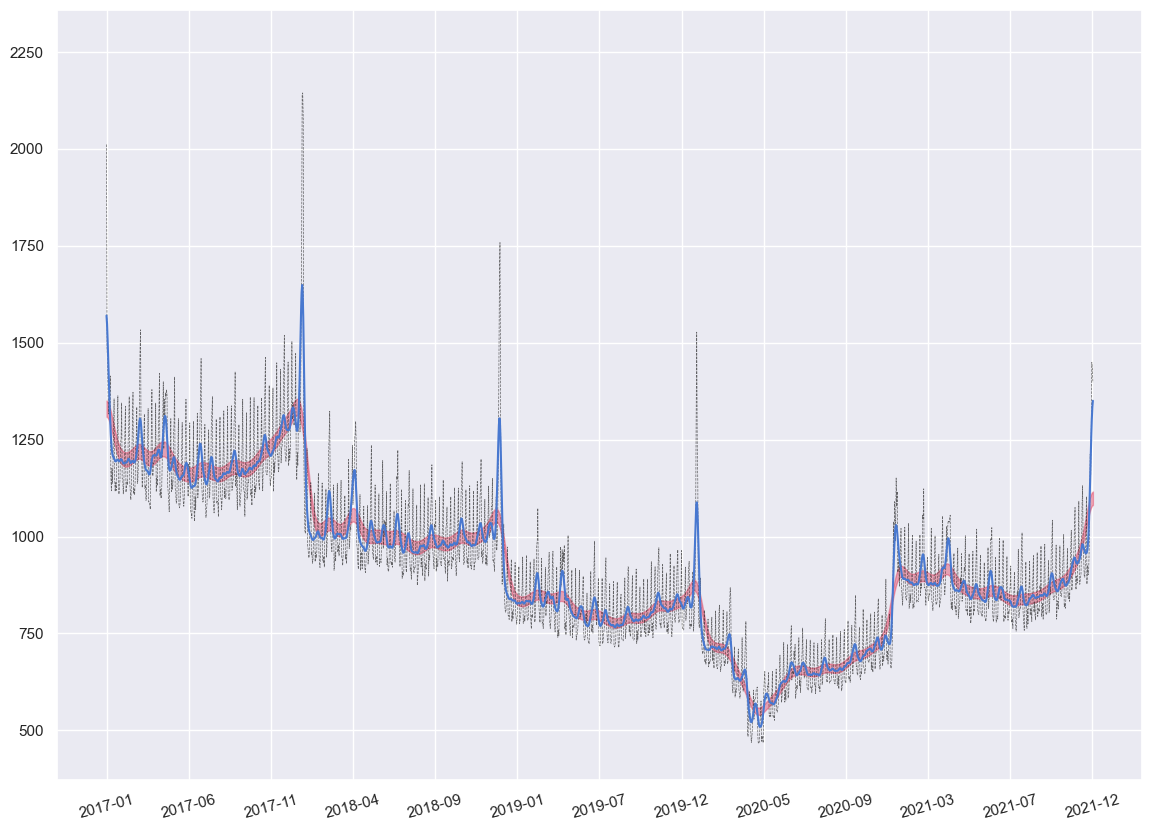

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
date_range = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
total_column = df['Total']

# Align data and date range (if necessary)
if len(df) != len(date_range):
    df = df.reindex(date_range, fill_value=np.nan)  # Reindex to match date range

# Select data based on reindexed DataFrame (if necessary)
total_column = df['Total']

# Apply Gaussian filter for smoothing
Final_array_smooth = gaussian_filter1d(total_column.to_numpy(), sigma=3)

# Error formatting (assuming 'Total' is the first column and errors are in subsequent columns)
upper_err = gaussian_filter1d(total_column.to_numpy() + (df.iloc[:, 1].to_numpy() / 2), sigma=12)
lower_err = gaussian_filter1d(total_column.to_numpy() - (df.iloc[:, 1].to_numpy() / 2), sigma=12)

# Plot lines and shaded area
ax.plot(total_column.index, total_column, '--', linewidth=0.5, color='k', alpha=0.65)  # Plot original data with DateTimeIndex
ax.plot(total_column.index, Final_array_smooth)  # Plot smoothed data with DateTimeIndex
ax.fill_between(total_column.index, upper_err, lower_err, color='crimson', alpha=0.35)  # Plot error shade with DateTimeIndex

# Adjust y-axis limits based on 'Total' column
ax.set_ylim(np.min(total_column) - (np.min(total_column) * 20) / 100,
            np.max(total_column) + (np.max(total_column) * 10) / 100)


num_ticks = 12  # Dostosuj liczbę ticków według potrzeb
date_range = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
tick_positions = np.arange(0, len(date_range), len(date_range) // num_ticks)
ax.set_xticks(date_range[tick_positions])
date_format = "%Y-%m"
formatter = mdates.DateFormatter(date_format)

# Ustaw formater dla osi x
ax.xaxis.set_major_formatter(formatter)

# Rotates x-axis labels for better readability with many dates
plt.xticks(rotation=15)
plt.show()

## LSTM

In [22]:
# Dane
data = df['Total']
tscv = TimeSeriesSplit(n_splits=7, max_train_size=715, test_size=150)

# Funkcja do przygotowania danych dla LSTM
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):  # Subtract 1 more to account for y at t+1
        a = dataset[i:(i + look_back)]
        X.append(a)
        y.append(dataset[i + look_back + 1])  # Add 1 to get the value at t+1
    return np.array(X), np.array(y)

# Nowa funkcja tworzenia modelu
def create_and_compile_model(trial, lags):
    recurrent_units = trial.suggest_int('units', 16, 256)
    dense_units = trial.suggest_int('dense', 16, 256)
    dropout_rate = trial.suggest_float('dropout', 0.02, 0.32)
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs= trial.suggest_int('epochs', 50, 200)
    optimizer = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])


    model = Sequential()
    model.add(LSTM(recurrent_units, activation='tanh', return_sequences=True, input_shape=(lags, 1)))
    model.add(LSTM(recurrent_units, activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.summary()
    # Kompilacja modelu z wybranym optymalizatorem i learning rate
    optimizer = getattr(tf.keras.optimizers, optimizer)(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model, batch_size, epochs, optimizer

# Funkcja celu Optuna
def objective(trial):
    look_back = trial.suggest_int('look_back', 31, 364)

    scores = []
    for train_index, test_index in tscv.split(data):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = X_train[look_back:], X_test[look_back:]

        # Prepare data for LSTM 
        X_train, y_train = create_dataset(X_train, look_back)
        X_test, y_test = create_dataset(X_test, look_back)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # Budowa i kompilacja modelu
        model, batch_size, epochs, optimizer = create_and_compile_model(trial, look_back)

        # Callbacks
        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

        # Trenowanie modelu
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                  validation_data=(X_test, y_test), callbacks=[TFKerasPruningCallback(trial, 'loss'), early_stopping],
                  verbose=1)

        # Ocena modelu
        score = model.evaluate(X_test, y_test, verbose=0)
        scores.append(score)

    return np.mean(scores)

# Uruchomienie Optuna z integracją TensorFlow
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100)

# Najlepsze parametry
print("Najlepsze parametry:", study.best_params)

[I 2024-06-03 20:20:10,141] A new study created in memory with name: no-name-eecd2f85-54b2-4015-bc84-48e47de2fd3e
C:\Users\domin\AppData\Local\Temp\ipykernel_113308\3241000377.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(dataset[i + look_back + 1])  # Add 1 to get the value at t+1
[W 2024-06-03 20:20:10,153] Trial 0 failed with parameters: {'look_back': 340} because of the following error: IndexError('tuple index out of range').
Traceback (most recent call last):
  File "C:\Users\domin\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\domin\AppData\Local\Temp\ipykernel_113308\3241000377.py", line 51, in objective
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.sh

IndexError: tuple index out of range

In [16]:
tscv = TimeSeriesSplit(n_splits=7, max_train_size=715, test_size=150)  
for fold_idx, (train_index, test_index) in enumerate(tscv.split(df['Total'])):
    print(f"\nStarting Fold {fold_idx}...")
    print(f"  Train data shape: {df['Total'].iloc[train_index].shape}")
    print(f"  Test data shape: {df['Total'].iloc[test_index].shape}")
    
    # Display start and end indices for training and test sets
    print("  Train data indices:", train_index[0], "-", train_index[-1])
    print("  Test data indices:", test_index[0], "-", test_index[-1])
    
    y_train, y_test = df['Total'].iloc[train_index], df['Total'].iloc[test_index]



Starting Fold 0...
  Train data shape: (715,)
  Test data shape: (150,)
  Train data indices: 61 - 775
  Test data indices: 776 - 925

Starting Fold 1...
  Train data shape: (715,)
  Test data shape: (150,)
  Train data indices: 211 - 925
  Test data indices: 926 - 1075

Starting Fold 2...
  Train data shape: (715,)
  Test data shape: (150,)
  Train data indices: 361 - 1075
  Test data indices: 1076 - 1225

Starting Fold 3...
  Train data shape: (715,)
  Test data shape: (150,)
  Train data indices: 511 - 1225
  Test data indices: 1226 - 1375

Starting Fold 4...
  Train data shape: (715,)
  Test data shape: (150,)
  Train data indices: 661 - 1375
  Test data indices: 1376 - 1525

Starting Fold 5...
  Train data shape: (715,)
  Test data shape: (150,)
  Train data indices: 811 - 1525
  Test data indices: 1526 - 1675

Starting Fold 6...
  Train data shape: (715,)
  Test data shape: (150,)
  Train data indices: 961 - 1675
  Test data indices: 1676 - 1825


In [ ]:
tscv = TimeSeriesSplit(n_splits=7, max_train_size=715, test_size=150)  
for train_index, val_index in tscv.split(df['Total']):
        X_train, X_val = df['Total'].values[train_index[:-lags]], df['Total'].values[val_index[:-lags]]
        y_train, y_val = df['Total'].values[train_index[lags:]], df['Total'].values[val_index[lags:]]

In [19]:
df['Total'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Freq: D
Series name: Total
Non-Null Count  Dtype  
--------------  -----  
1826 non-null   float32
dtypes: float32(1)
memory usage: 21.4 KB
